#Project Overview: Cognitive Wellbeing Monitoring

Our project analyzes mental health trends worldwide by looking at DALYs (Disability-Adjusted Life Years) for mental disorders.
We use historical data to:

1.Forecast future trends

2.dentify high-risk countries

3.Provide visual insights for policymakers or researchers

The goal is to monitor cognitive wellbeing and highlight areas where interventions might be needed.

###1. Import Libraries
Imports all tools needed for:

Data manipulation (pandas, numpy)

Visualization (matplotlib, seaborn, plotly)

Machine learning models (RandomForestRegressor, RandomForestClassifier)

Model evaluation (RMSE, R², classification report, confusion matrix)

Explainability (shap)

Why it matters: These libraries provide the core functionality to process data, train models, and make insights understandable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix


###2. Load and Prepare Datasets

Reads two CSV files containing historical DALY data.

Renames the long column name to DALY_percent for simplicity.

In [2]:
file1 = "/content/drive/MyDrive/Colab Notebooks/VOIS PROJECT/1719220003-mental-and-substance-use-as-share-of-disease -AI (5).csv"
file2 = "/content/drive/MyDrive/Colab Notebooks/VOIS PROJECT/1719220036-mental-and-substance-use-as-share-of-disease -AI (4).csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Standardize column name
for df in [df1, df2]:
    df.rename(columns={ 'DALYs (Disability-Adjusted Life Years) - Mental disorders - Sex: Both - Age: All Ages (Percent)': 'DALY_percent'}, inplace=True)


###3. Encode Countries

Converts country names into numbers (e.g., India → 5, USA → 20).

Why it matters: Machine learning models cannot handle text labels, so encoding allows them to process countries as features.

In [3]:
le = LabelEncoder()
df['Entity_encoded'] = le.fit_transform(df['Entity'])


###4. Regression (Forecasting DALY %)

Uses Year and Country to predict DALY %.

Splits data into training and testing sets.

Trains a Random Forest Regressor.

Predicts DALY % for test data.

Why it matters:

Allows us to forecast DALY % for future years and understand past trends.

In [4]:
X = df[['Year', 'Entity_encoded']]
y = df['DALY_percent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = RandomForestRegressor(n_estimators=300, random_state=42)
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)


###Regression Evaluation

Measures model performance:

RMSE → average prediction error

R² → how well the model explains variance

In [5]:
print("Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Regression R²:", r2_score(y_test, y_pred))


Regression RMSE: 0.19410504295310552
Regression R²: 0.9925930277671235


###Forecasting 5 Future Years

Predicts DALY % for 5 years beyond historical data.

Plots historical vs forecasted trends.

In [6]:
# Loop over countries to predict future DALY %
future_years = np.arange(df['Year'].max()+1, df['Year'].max()+6)


###5. Classification (High-Risk vs Low-Risk)

Creates a binary label: 1 → High-risk, 0 → Low-risk (top 25% DALY).

Trains a Random Forest Classifier to predict high-risk years.

Why it matters:

Highlights countries and years at high risk for mental health burden.

In [7]:
threshold = df["DALY_percent"].quantile(0.75)
df["Risk_Label"] = np.where(df["DALY_percent"] >= threshold, 1, 0)

Xc = df[['Year', 'Entity_encoded']]
yc = df['Risk_Label']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(Xc_train, yc_train)

yc_pred = clf.predict(Xc_test)


###Classification Evaluation

Evaluates classifier accuracy (precision, recall, f1-score).

Plots confusion matrix to show true vs predicted risk labels.

Why it matters: Checks if high-risk predictions are reliable.

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1044
           1       0.33      0.34      0.33       324

    accuracy                           0.68      1368
   macro avg       0.56      0.56      0.56      1368
weighted avg       0.68      0.68      0.68      1368



<Axes: >

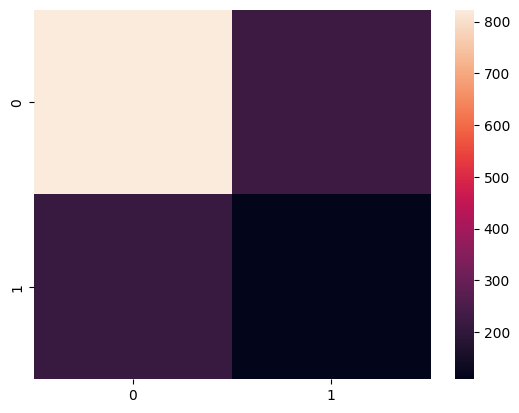

In [8]:
print(classification_report(yc_test, yc_pred))
sns.heatmap(confusion_matrix(yc_test, yc_pred))

###6. Feature Importance + SHAP

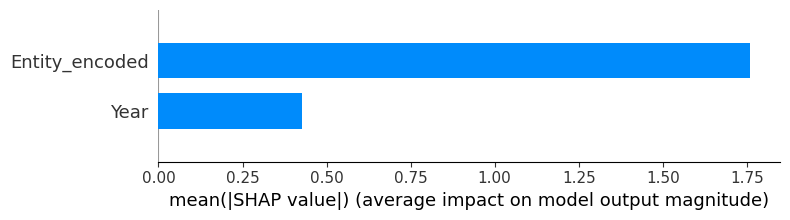

In [9]:
feat_importances = pd.Series(clf.feature_importances_, index=Xc.columns)
feat_importances.plot(kind='barh')

explainer = shap.TreeExplainer(reg_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


###7. Dashboard-Like Plots

Historical + Forecast line plots for each country

Risk Summary bar chart (proportion of high-risk years)

What it does:

Combines important visualizations in one view.

Why it matters: Allows a quick, intuitive understanding of cognitive wellbeing trends across countries.

In [11]:
# Latest year data for world map
latest_year = df['Year'].max()
latest_df = df[df['Year'] == latest_year]


###World Map Visualization

Shows DALY % for all countries on a world map.

Colors indicate severity of mental health burden.

In [14]:
import plotly.express as px

# Make sure latest_df is defined (latest year)
latest_year = df['Year'].max()
latest_df = df[df['Year'] == latest_year]

# Create choropleth map
fig = px.choropleth(
    latest_df,
    locations="Entity",           # Column with country names
    locationmode='country names', # Recognizes full country names
    color="DALY_percent",         # Value to color-code
    hover_name="Entity",          # Show country names on hover
    hover_data={"DALY_percent": True, "Entity_encoded": False},  # Show DALY %, hide code
    color_continuous_scale=px.colors.sequential.Reds,
    title=f"Global DALYs % (Mental Disorders) - {latest_year}"
)

# Optional: Add country names as annotations (for a few major countries)
# This is useful if you want some labels visible without hovering
for i, row in latest_df.iterrows():
    fig.add_scattergeo(
        locations=[row['Entity']],
        locationmode='country names',
        text=row['Entity'],
        mode='text',
        showlegend=False
    )

# Display the map
fig.show()

